In [86]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.preprocessing import MinMaxScaler
import string
from nltk.corpus import stopwords
from tensorflow.keras.regularizers import l2

# Download necessary NLTK resources
# nltk.download('punkt')
# nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
# Define directories for each dataset
directories = {
    'agoda_hotel_reviews': (1, 10),  
    'tripadvisor_hotel_reviews': (1, 5),
    'klook_hotel_reviews': (1, 5),  
    'booking_hotel_reviews': (1, 10)
}

In [87]:
# Function to load and normalize data
def load_and_normalize_data():
    all_reviews = []
    for directory, (min_score, max_score) in directories.items():           
        path = os.path.join('raw data', directory)
        for filename in os.listdir(path):
            if filename.endswith('.csv'):
                df = pd.read_csv(os.path.join(path, filename))
                scaler = MinMaxScaler(feature_range=(0, 1))
                df['normalized_score'] = scaler.fit_transform(df[['Review Score']])
                all_reviews.append(df)
    return pd.concat(all_reviews, ignore_index=True)

# Load and normalize data
df = load_and_normalize_data()

In [88]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
# Function to lemmatize text and check if it's in English
def preprocess_text(text):
    try:
        # Check if the review is in English
        lang = detect(text)
        if lang != 'en':
            return None  # Return None if not in English

        # Step 1: Convert text to lowercase
        text = text.lower()

        # Step 2: Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Step 3: Tokenization
        tokens = nltk.word_tokenize(text)

        # Step 4: Remove stop words
        tokens = [word for word in tokens if word not in stop_words]

        # Step 5: Lemmatization
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

        # Return the processed text as a single string
        return ' '.join(lemmatized_tokens)

    except LangDetectException as e:
        # Print the exception message
        print(f'An error occurred: {e}')
        return None

# Apply preprocessing to the DataFrame column
df['cleaned_content'] = df['Review Content'].apply(preprocess_text)

# Identify and print the removed reviews
removed_reviews = df[df['cleaned_content'].isnull()]['Review Content']
print("Removed reviews:")
print(removed_reviews)
# Drop rows where 'cleaned_content' is None (non-English reviews)
df = df.dropna(subset=['cleaned_content'])


An error occurred: No features in text.
An error occurred: No features in text.
An error occurred: No features in text.
An error occurred: No features in text.
An error occurred: No features in text.
An error occurred: No features in text.
An error occurred: No features in text.
An error occurred: No features in text.
An error occurred: No features in text.
An error occurred: No features in text.
An error occurred: No features in text.
Removed reviews:
2                              My favorite hotel\r\n \r\n 
11                                     Excellent\r\n \r\n 
31       Napakaganda ang mura pa dito ulit ako mag ssta...
43                                         Good \r\n \r\n 
45                    No frills, reliable hotel.\r\n \r\n 
                               ...                        
10089       \r\n Buffet breakfast and dinner\r\n No issues
10134                \r\n very good room attendant\r\n n/a
10152                                     \r\n Buffet\r\n 
10155    \r\

In [89]:
# Convert normalized scores to binary labels (1 for positive, 0 for negative)
df['label'] = df['normalized_score'].apply(lambda x: 0 if x <= 0.25 else (2 if x >= 0.75 else 1))
print(df['label'])
print(df.head())    

print(df[['normalized_score', 'label']].describe())


0        2
1        2
3        2
4        2
5        2
        ..
10237    2
10238    2
10239    1
10240    2
10241    2
Name: label, Length: 9811, dtype: int64
  Review Provider  Review ID  \
0           Agoda  831639368   
1           Agoda  830646554   
3           Agoda  830828036   
4           Agoda  823596890   
5           Agoda  830566146   

                                      Review Content  Review Score  \
0  The hotel's facilities were top notch, from th...           9.6   
1  I enjoyed my stay at the Bai Hotel. The prices...          10.0   
3  This hotel was so accommodating. Good staff, g...          10.0   
4                         Well recommended\r\n \r\n           10.0   
5           one of the best places to stay\r\n \r\n           10.0   

                 Review Time  normalized_score  \
0  2024-07-16T09:26:00+07:00              0.95   
1  2024-07-15T12:05:00+07:00              1.00   
3  2024-07-15T04:07:00+07:00              1.00   
4  2024-07-14T07:00:00+07

In [90]:
# Count the occurrences of each label
positive_count = (df['label'] == 2).sum()
negative_count = (df['label'] == 0).sum()
neutral_count = (df['label'] == 1).sum()

# Print the counts
print(f'Positive reviews: {positive_count}')
print(f'Negative reviews: {negative_count}')
print(f'Neutral reviews: {neutral_count}')
print(f"Total: {df['label'].count()}")

Positive reviews: 8020
Negative reviews: 383
Neutral reviews: 1408
Total: 9811


In [91]:
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_content'])

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_content'])
# Find the length of each sequence
# sequence_lengths = [len(seq) for seq in sequences]

# # Get the maximum sequence length
# max_length = max(sequence_lengths)
# print(max_length)

padded_sequences = pad_sequences(sequences, maxlen=100)

# Prepare labels
labels = df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.3, stratify=labels, random_state=42)
# Instantiate the SMOTE object


Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.8164 - loss: 0.7248 - val_accuracy: 0.8122 - val_loss: 1.0217
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.8290 - loss: 0.5426 - val_accuracy: 0.8159 - val_loss: 0.7440
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.8719 - loss: 0.4222 - val_accuracy: 0.8341 - val_loss: 0.5206
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.9052 - loss: 0.3380 - val_accuracy: 0.8326 - val_loss: 0.5234
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.9416 - loss: 0.2683 - val_accuracy: 0.8253 - val_loss: 0.5813
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9601 - loss: 0.2156 - val_accuracy: 0.8261 - val_loss: 0.6542
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.9688 - loss: 0.1763 - val_accuracy: 0.7453 - val_loss: 0.8113
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.9704 - loss: 0.1537 - 

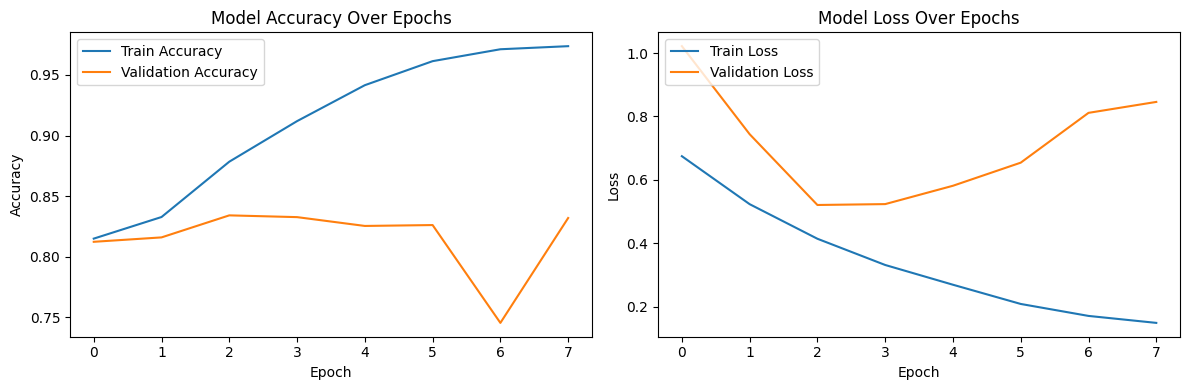

In [97]:
# Model creation
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
model = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    Conv1D(filters=64, kernel_size=5, activation='relu'), 
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=True)), 
    BatchNormalization(),
    Bidirectional(LSTM(64)), 
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
from tensorflow.keras.optimizers import Adam
# Model Compilation
model.compile(optimizer=Adam(learning_rate= 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model Training
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Model Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')  # Rounded to 4 decimal places for clarity

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [93]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example input reviews
new_reviews = [
    {"review": "The hotel staff was incredibly helpful and the room was clean and spacious. Definitely a positive experience!", "score": 1.0},
    {"review": "The location was good, but the room had a strange smell and the service was just okay.", "score": 0.6},
    {"review": "I had a terrible stay. The room was dirty and the staff was rude. Not worth the price.", "score": 0.2},
    {"review": "Amazing experience! The view from the room was breathtaking and the food at the restaurant was top-notch.", "score": 1.0},
    {"review": "The room was decent, but the Wi-Fi was slow and unreliable. It was an average stay overall.", "score": 0.5},
    {"review": "Terrible service! We waited over an hour for our room to be ready and the staff was not apologetic.", "score": 0.3},
    {"review": "The hotel was in a perfect location, close to all the major attractions. The room was comfortable and well-maintained.", "score": 0.9},
    {"review": "The facilities were outdated, and the air conditioning barely worked. I was disappointed with my stay.", "score": 0.4},
    {"review": "Great value for money! The hotel offered a lot of amenities and the staff was very friendly.", "score": 0.8},
    {"review": "The breakfast was good, but the room was small and the bed was uncomfortable. It was an okay stay.", "score": 0.6}
]

# Define a function to preprocess new input data
def preprocess_new_data(new_data):
    # Apply the same preprocessing function
    cleaned_data = [preprocess_text(entry["review"]) for entry in new_data]
    
    # Convert to sequences using the trained tokenizer
    sequences = tokenizer.texts_to_sequences(cleaned_data)
    
    # Pad the sequences
    padded_sequences = pad_sequences(sequences, maxlen=100)  # Use the same maxlen as your training data

    return padded_sequences

# Prepare reviews for prediction
padded_sequences = preprocess_new_data(new_reviews)

# Make predictions
predictions = model.predict(padded_sequences)

# Interpreting the predictions
for i, prediction in enumerate(predictions):
    predicted_label = np.argmax(prediction)  # Get the index of the highest probability
    predicted_score = prediction[predicted_label]  # The probability of the predicted class
    actual_score = new_reviews[i]["score"]

    # Assign sentiment based on the predicted label
    sentiment_labels = ['Negative', 'Neutral', 'Positive']
    sentiment = sentiment_labels[predicted_label]

    # Print the results
    print(f"Review: {new_reviews[i]['review']}")
    print(f"Actual Score: {actual_score:.2f}")
    print(f"Predicted Label: {sentiment}")
    print(f"Negative Probability: {prediction[0]:.2f}")
    print(f"Neutral Probability: {prediction[1]:.2f}")
    print(f"Positive Probability: {prediction[2]:.2f}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
Review: The hotel staff was incredibly helpful and the room was clean and spacious. Definitely a positive experience!
Actual Score: 1.00
Predicted Label: Positive
Negative Probability: 0.04
Neutral Probability: 0.14
Positive Probability: 0.82
--------------------------------------------------
Review: The location was good, but the room had a strange smell and the service was just okay.
Actual Score: 0.60
Predicted Label: Positive
Negative Probability: 0.13
Neutral Probability: 0.36
Positive Probability: 0.50
--------------------------------------------------
Review: I had a terrible stay. The room was dirty and the staff was rude. Not worth the price.
Actual Score: 0.20
Predicted Label: Neutral
Negative Probability: 0.16
Neutral Probability: 0.42
Positive Probability: 0.42
--------------------------------------------------
Review: Amazing experience! The view from the room was breathtaking and the food at the restaurant was top-notch.
Actual Score

In [94]:
from datetime import datetime
import os

# Assuming `model` is your Keras model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f'saved_models/general_sentiment_softmax_{timestamp}.keras'

# Make sure the directory exists
os.makedirs(os.path.dirname(file_name), exist_ok=True)

# Save the model with the unique file name
model.save(file_name)
print(f"Model saved as {file_name}")
model.summary()

Model saved as saved_models/general_sentiment_softmax_20240828_232544.keras


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)        │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 96, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_54                │ (None, 48, 128)        │        66,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 48, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_55                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,564,043 (9.78 MB)

 Trainable params: 854,595 (3.26 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 1,709,192 (6.52 MB)